## 1. Importing all necessary libraries

In [1]:
import pandas as pd
import numpy as np

import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 2. Reading Lyrics Data from a csv file and storing in a dataframe.

- Importing data then dropping any NA values and then tokenizing it.
- Plotting document length.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/LyricLab original copy/ed_sheeran_cleaned_songs.csv')  # Load dataset

In [4]:
df.dropna(inplace=True)

<ipython-input-5-f3f06d9211db>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

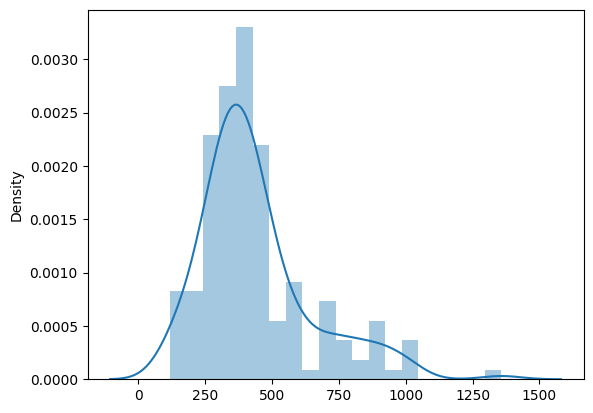

In [5]:
doc_lengths = []

for lyrics in df['Lyrics']:

    # get rough token count distribution
    tokens = nltk.word_tokenize(lyrics)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [6]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.10227272727272728

In [7]:
np.average(doc_lengths)

438.96022727272725

## 3. Loading GPT2 Tokenizer and preparing data for model training

In [8]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [9]:
batch_size = 2 # setting batch size as 2 to avoid out of memory problems.

### Custom Dataset class for preparing text data for GPT-2 model training.

#### Attributes:
-----------
tokenizer : transformers.PreTrainedTokenizer
    The tokenizer to be used for encoding the text.

input_ids : List[torch.Tensor]
    List of input ID tensors for each text sample.

attn_masks : List[torch.Tensor]
    List of attention mask tensors for each text sample.

#### Methods:
--------
__len__():
    Returns the number of samples in the dataset.
    
__getitem__(idx):
    Returns the input ID tensor and attention mask tensor for a given index.

In [10]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [11]:
# Create the custom dataset using the 'Lyrics' column from the dataframe
dataset = GPT2Dataset(df['Lyrics'], tokenizer, max_length=768)

# Calculate the sizes for training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Print the number of samples in the training and validation sets
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  158 training samples
   18 validation samples


 - We can see dataset is fairly small, which might impact the performance and generalization ability of model.
 - Utilizing pretrained models like GPT-2, can significantly help because they have already been trained on large corpora. Fine-tuning such models on small dataset can yield better results than training from scratch.


In [12]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## 4. Fine Tune GPT2 Model

In [13]:
# Configuration
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# Resize token embeddings
# Adjust the model's token embeddings to match the size of the tokenizer.
# This ensures that the model can handle the same vocabulary size as the tokenizer.
model.resize_token_embeddings(len(tokenizer))

# Use GPU for training
# Specify that the model should be run on the GPU, if available.

device = torch.device("cuda")
model.cuda()

# Uncomment below two lines to run on CPU and comment above two lines
#device = torch.device("cpu")
#model.to(device)


# Set seed for reproducibility
# Fixing the seed for various random number generators to ensure reproducible results.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Setting hyperparameters

- Having multiple configuration of hyperparameters to check how the model performs
- Epoch will be a list of 3 values  [1,5,8]

- Learning Rate will be a list of 5 values [0.1,0.01,0.001,0.0005]

- Warmup Steps will be 1e2


In [14]:
epochs = [1,2,5]
learning_rate =  [0.1,0.01,0.001,0.0005]
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

#### Optimizer and Scheduler Setup

- **get_optimizer**(learning_rate, epsilon, model)

This function initializes the AdamW optimizer for the model with the specified learning rate and epsilon.

- Parameters:
learning_rate: The learning rate for the optimizer.

epsilon: A small value to prevent division by zero.

model: The model to optimize.

- Returns:
The AdamW optimizer instance.

- **get_scheduler**(train_dataloader, optimizer, epochs, warmup_steps)

This function sets up a learning rate scheduler with a linear warmup followed by linear decay.

- Parameters:

train_dataloader: DataLoader with training data.

optimizer: The optimizer for which to schedule the learning rate.

epochs: Number of training epochs.

warmup_steps: Steps to linearly increase the learning rate at the start.

- Returns:
The learning rate scheduler instance.

In [15]:
def get_optimizer(learning_rate, epsilon, model):
  optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
  return optimizer

  # Total number of training steps is [number of batches] x [number of epochs].
  # (Note that this is not the same as the number of training samples).

def get_scheduler(train_dataloader,optimizer, epochs, warmup_steps):
  # Total number of training steps is [number of batches] x [number of epochs].
  total_steps = len(train_dataloader) * epochs
  # Create the learning rate scheduler.
  # This changes the learning rate as the training loop progresses
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)
  return scheduler

In [16]:
# Defining time format function
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

## 5. Model Training
The train_model function trains a given model using the provided dataloader, optimizer, and scheduler, and performs validation at the end of each epoch while recording training statistics. The function takes several parameters: model, epoch, train_dataloader, tokenizer, optimizer, scheduler, and learning_rate. The training process consists of an outer loop that runs for the specified number of epochs. For each epoch, the model is set to training mode using model.train(), and it iterates over each batch in the train_dataloader. Inputs, labels, and masks are moved to the GPU, and gradients are zeroed using model.zero_grad(). The model outputs are computed, and the loss is extracted and accumulated. Every few steps, a sample output is generated for inspection. Gradients are computed using loss.backward(), and model parameters are updated with optimizer.step(). The learning rate is adjusted using scheduler.step().

After training, the model is set to evaluation mode using model.eval(), and it iterates over each batch in the validation_dataloader. Again, inputs, labels, and masks are moved to the GPU, and model outputs are computed in no-gradient mode using torch.no_grad(). Loss is calculated and accumulated. The average training and validation losses are printed, along with the time taken for each epoch. Training statistics are recorded in a list. At the end of all epochs, a completion message is printed with the total training time. An example usage of the function would be: train_model(model=model, epoch=3, train_dataloader=train_dataloader, tokenizer=tokenizer, optimizer=optimizer, scheduler=scheduler, learning_rate=5e-5).

In [17]:

def train_model(model,epoch,train_dataloader,tokenizer,optimizer,scheduler,learning_rate):
  total_t0 = time.time()

  model = model.to(device)

  for epoch_i in range(0, epoch):

    # ========================================
    #               Training
    # ========================================

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      t0 = time.time()

      total_train_loss = 0

      model.train()

      for step, batch in enumerate(train_dataloader):

          b_input_ids = batch[0].to(device)
          b_labels = batch[0].to(device)
          b_masks = batch[1].to(device)

          model.zero_grad()

          outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

          loss = outputs[0]

          batch_loss = loss.item()
          total_train_loss += batch_loss

          # Get sample every x batches.
          if step % sample_every == 0 and not step == 0:

              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

              model.eval()

              sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
              for i, sample_output in enumerate(sample_outputs):
                    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

              model.train()

          loss.backward()

          optimizer.step()

          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

      print("")
      print("Running Validation...")

      t0 = time.time()

      model.eval()

      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:

          b_input_ids = batch[0].to(device)
          b_labels = batch[0].to(device)
          b_masks = batch[1].to(device)

          with torch.no_grad():

              outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

              loss = outputs[0]

          batch_loss = loss.item()
          total_eval_loss += batch_loss

      avg_val_loss = total_eval_loss / len(validation_dataloader)

      validation_time = format_time(time.time() - t0)

      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

    #  Record all statistics from this epoch.
      training_stats.append(
          {   'Epoch': epoch,
              'Learning Rate': learning_rate,
              'sub_epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")
  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
## Model training looping over list of epochs and learning rate.

training_stats=[] # to store statistics related to each training step of all epoch and learning rate
for epoch in epochs:
  for lr in learning_rate:
    print(f"\n Epoch: {epoch}, Learning Rate: {lr}")
    optimizer = get_optimizer(lr, epsilon, model)
    scheduler = get_scheduler(train_dataloader,optimizer, epoch, warmup_steps)
    train_model(model,epoch,train_dataloader,tokenizer,optimizer,scheduler,lr)


 Epoch: 1, Learning Rate: 0.1


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / [1, 2, 5] ========
Training...

  Average training loss: 6.86
  Training epoch took: 0:00:37

Running Validation...
  Validation Loss: 4.05
  Validation took: 0:00:01

Training complete!
Total training took 0:00:38 (h:mm:ss)

 Epoch: 1, Learning Rate: 0.01

======== Epoch 1 / [1, 2, 5] ========
Training...

  Average training loss: 3.60
  Training epoch took: 0:00:38

Running Validation...
  Validation Loss: 3.18
  Validation took: 0:00:01

Training complete!
Total training took 0:00:39 (h:mm:ss)

 Epoch: 1, Learning Rate: 0.001

======== Epoch 1 / [1, 2, 5] ========
Training...

  Average training loss: 3.25
  Training epoch took: 0:00:39

Running Validation...
  Validation Loss: 3.01
  Validation took: 0:00:01

Training complete!
Total training took 0:00:40 (h:mm:ss)

 Epoch: 1, Learning Rate: 0.0005

======== Epoch 1 / [1, 2, 5] ========
Training...

  Average training loss: 3.15
  Training epoch took: 0:00:38

Running Validation...
  Validation Loss: 2.95
  Vali

### Printing training statistic

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
#df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats

,Epoch,Learning Rate,sub_epoch,Training Loss,Valid. Loss,Training Time,Validation Time
0,1,0.1000,1,6.861125,4.052580,0:00:37,0:00:01
1,1,0.0100,1,3.598105,3.176638,0:00:38,0:00:01
2,1,0.0010,1,3.252975,3.011552,0:00:39,0:00:01
3,1,0.0005,1,3.154221,2.950158,0:00:38,0:00:01
4,2,0.1000,1,4.125515,4.697136,0:00:38,0:00:01
5,2,0.1000,2,6.227862,4.252787,0:00:38,0:00:01
6,2,0.0100,1,4.195796,3.487024,0:00:38,0:00:01
7,2,0.0100,2,3.932605,3.358345,0:00:38,0:00:01
8,2,0.0010,1,3.706522,3.331152,0:00:38,0:00:01
9,2,0.0010,2,3.656477,3.275570,0:00:38,0:00:01


In [ ]:
# Saving Training statistics to a csv
df_stats.to_csv('/content/drive/MyDrive/LyricLab original/model_save/training_stats.csv')

## 6. Saving trained model

In [ ]:

output_dir = '/content/drive/MyDrive/LyricLab original/model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# saving your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/MyDrive/LyricLab original/model_save/


('/content/drive/MyDrive/LyricLab original/model_save/tokenizer_config.json',
 '/content/drive/MyDrive/LyricLab original/model_save/special_tokens_map.json',
 '/content/drive/MyDrive/LyricLab original/model_save/vocab.json',
 '/content/drive/MyDrive/LyricLab original/model_save/merges.txt',
 '/content/drive/MyDrive/LyricLab original/model_save/added_tokens.json')

## 7. Generating text using trained model

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[50257]], device='cuda:0')
0:  But I,, to you,, me the the my to, and's that we my,,, me you, the,,, me,, my,, a,'m,, you your on your,, to the, I on you't, love my,,,'t you the,-, it now,, you,'t me,'t oh,, a to you the to a, and I, But


1:  I I you, me to you, I you to,, you it I I the on that on to, on a, I, it don, with the- the to a I the,, me I, your, and the, And I to, you I, I, you we now, and'm my, my'm I on don, a,, me, in, it, my,'m you, the, the You in it on now,,,'t on with,'m that of we, I it on I the,, But and I a my'll,, all You,


2: ,, be it,, I I in the I, you you know be a my you,,, you your you to me know oh,,, I, you And I the the,,, I'm I I, me, your me the And to now to I and you's,, the the, And and'm,'s,'t to's, I I,,, And,,, I, the I a oh,, And, now,,, And it, And But, love




#### We can observe the trained lyrics are not that good that can be because of multiple training on the same model over multiple epochs and learning rate. We will check for single configuration and will compare the lyrics.

### Checking for single epoch and learning rate

- Defining new model from pretrained GPT2 model.
- Running over epoch set as 5 and learning rate as 0.0005
- Generating text from the trained model.

In [18]:
# Configuration
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model_with_one_configuration = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because of addition of bos_token, etc to the embeddings
# otherwise the tokenizer and model tensors won't match up
model_with_one_configuration.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model_with_one_configuration.cuda()

## Uncomment below two lines to run on CPU and comment above two lines
#device = torch.device("cpu")
#model_with_one_configuration.to(device)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
training_stats=[]
epoch = 5
lr = 0.0005
print(f"\n Epoch: {epoch}, Learning Rate: {lr}")
optimizer = get_optimizer(lr, epsilon, model_with_one_configuration)
scheduler = get_scheduler(train_dataloader,optimizer, epoch, warmup_steps)
train_model(model_with_one_configuration,epoch,train_dataloader,tokenizer,optimizer,scheduler,lr)


 Epoch: 5, Learning Rate: 0.0005

======== Epoch 1 / [1, 2, 5] ========
Training...


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



  Average training loss: 1.22
  Training epoch took: 0:00:41

Running Validation...
  Validation Loss: 1.30
  Validation took: 0:00:01

======== Epoch 2 / [1, 2, 5] ========
Training...

  Average training loss: 1.06
  Training epoch took: 0:00:40

Running Validation...
  Validation Loss: 1.09
  Validation took: 0:00:01

======== Epoch 3 / [1, 2, 5] ========
Training...

  Average training loss: 0.66
  Training epoch took: 0:00:40

Running Validation...
  Validation Loss: 0.93
  Validation took: 0:00:01

======== Epoch 4 / [1, 2, 5] ========
Training...

  Average training loss: 0.35
  Training epoch took: 0:00:40

Running Validation...
  Validation Loss: 0.91
  Validation took: 0:00:01

======== Epoch 5 / [1, 2, 5] ========
Training...

  Average training loss: 0.20
  Training epoch took: 0:00:40

Running Validation...
  Validation Loss: 0.89
  Validation took: 0:00:01

Training complete!
Total training took 0:03:26 (h:mm:ss)


In [28]:
model_with_one_configuration.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model_with_one_configuration.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0:  on me like he told me, Burning fires in this room, I don't know where we're gonna go, But go ahead and drive I will, See I will, I will burn everything down, And when God takes you back we will say the words, And I will drive you home, And I will make your night sky, as bright and as free, A beautiful place to make your night, And I will make your bed, And I will make your day, And I will make your bedgown, And I will make your bed spread, And I will make your bed spread, And I will make your bed spread Your love was handmade for somebody like me, Come on now, follow my lead, I may be crazy, don't mind me Say the word, and I will, Take my hand, Take my hand, Stop, Put "Van the Man" on the jukebox, And then we will go silent, Go How long you leaving?, Cause this deadbeat town still looks so perfect, And you keep on crying, And I know I will, I will burn this whole house down, And I will make your bed spread, And I will make your bed, And I will mak

In [29]:
# Create a DataFrame from our training statistics.
df_stats_one_config = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats_one_config = df_stats_one_config.set_index('sub_epoch')
# Display the table.
df_stats_one_config

,Epoch,Learning Rate,Training Loss,Valid. Loss,Training Time,Validation Time
sub_epoch,,,,,,
1,5,0.0005,1.216363,1.297257,0:00:41,0:00:01
2,5,0.0005,1.058841,1.091444,0:00:40,0:00:01
3,5,0.0005,0.659993,0.927446,0:00:40,0:00:01
4,5,0.0005,0.352772,0.905132,0:00:40,0:00:01
5,5,0.0005,0.202642,0.886572,0:00:40,0:00:01


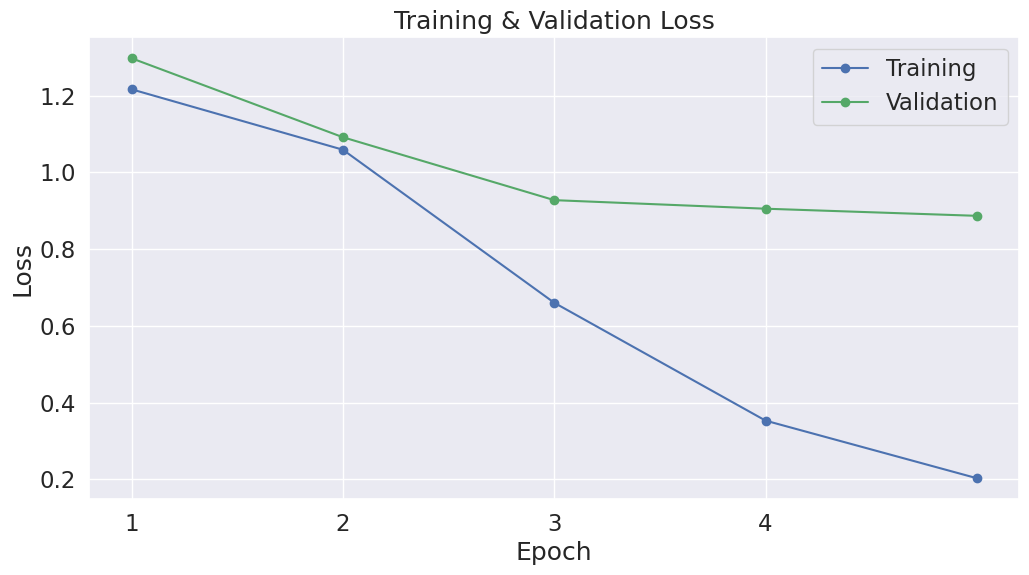

In [30]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats_one_config['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats_one_config['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# MODEL EVALUATION

## 1. Computing Perplexity for training and validation data loader

In [31]:
def get_perplexity(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_steps = 0

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids = batch[0].to(device)
            b_labels = batch[0].to(device)
            b_masks = batch[1].to(device)

            outputs = model(b_input_ids,
                            labels=b_labels,
                            attention_mask=b_masks)

            loss = outputs[0]
            total_loss += loss.item()
            total_steps += 1

    avg_loss = total_loss / total_steps
    perplexity = np.exp(avg_loss)

    return perplexity

In [44]:
# Compute perplexity on the validation dataset
val_perplexity = get_perplexity(model_with_one_configuration, validation_dataloader, device)
print(f'Validation Perplexity: {val_perplexity}')

Validation Perplexity: 2.426796710223497


In [45]:
# Compute perplexity on the training dataset
train_perplexity = get_perplexity(model_with_one_configuration, train_dataloader, device)
print(f'Train Perplexity: {train_perplexity}')

Train Perplexity: 1.1086199390533467


### Perplexity Scores and Their Interpretations

- Train Perplexity: 1.1086

Interpretation: This score indicates how well the model performs on the training data. A lower perplexity means that the model predicts the training data more accurately. Since this perplexity is quite low, it suggests that the model fits the training data very well. However, a very low training perplexity might also indicate overfitting, where the model learns the training data too well but may not generalize effectively to new, unseen data.

- Validation Perplexity: 2.4268

Interpretation: This score reflects the model’s performance on the validation set. The validation perplexity is higher than the training perplexity, which is common and indicates that the model does not perform as well on unseen data compared to the data it was trained on. A validation perplexity of 2.4268 suggests that while the model is generally good, there is room for improvement in terms of generalization to new data. The model's performance on the validation set should ideally be close to the training performance to ensure that it is not overfitting.

#### In summary:

Lower perplexity generally means better performance, indicating that the model predicts the data more accurately.
A significant difference between training and validation perplexity might indicate overfitting or issues with the model’s generalization capability.


## 2. Computing Cosine Similarity

In [41]:
from sentence_transformers import SentenceTransformer, util

# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define your sentences
generated_sentence = "You are the one, girl, And you know it, she knows it, She's like glue, She holds my heart in her hands, Says, I need you now, baby, I need you now, baby, I need you now, Hold on So I can safely go home I can safely go home, I'm on my way, Driving at 90 down those country lanes, Singing to Tiny Dancer, And I need you now, babe, Hold on So I can safely go home And I can safely go home See my family, We're just kids, We're not kids, We're just kids, We're left here, sitting here,, Wishing I was here, Baby I know, She's holding mine Baby, I'm heart is all I own, I'll never trust her again, Hold on So I can safely go home I can safely go home And I can safely go home And I can safely go home And I can safely go home And I can safely go home, And I can safely go home"
reference_sentence = "I found a love for me, Darling, just dive right in and follow my lead, Well, I found a girl, beautiful and sweet, Oh, I never knew you were the someone waiting for me, 'Cause we were just kids when we fell in love, Not knowing what it was, I will not give you up this time, But darling, just kiss me slow, your heart is all I own, And in your eyes you're holding mine Baby, I'm dancing in the dark with you between my arms, Barefoot on the grass, listening to our favorite song, When you said you looked a mess, I whispered underneath my breath, But you heard it, darling, you look perfect tonight Well I found a woman, stronger than anyone I know, She shares my dreams, I hope that someday I'll share her home, I found a love, to carry more than just my secrets, To carry love, to carry children of our own, We are still kids, but we're so in love, Fighting against all odds, I know we'll be alright this time, Darling, just hold my hand, Be my girl, I'll be your man, I see my future in your eye"

# Generate embeddings
embedding1 = model.encode(generated_sentence, convert_to_tensor=True)
embedding2 = model.encode(reference_sentence, convert_to_tensor=True)

# Compute cosine similarity
similarity = util.pytorch_cos_sim(embedding1, embedding2)
print(f"Cosine Similarity: {similarity.item():.4f}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cosine Similarity: 0.7358


## Cosine Similarity and their interpretation

##### Cosine similarity is used to measure how similar two text embeddings are by comparing the angle between their vector representations. By computing the cosine similarity between two embeddings, you determine how closely related the textual content of the embeddings is, regardless of their magnitude. A cosine similarity close to 1 indicates that the embeddings are very similar in their semantic meaning. Conversely, a similarity close to 0 suggests that the embeddings are not closely related, and a similarity close to -1 implies that they are opposite in meaning.

- The cosine similarity score of 0.7358 indicates a notable degree of semantic similarity between the two sentences.

- A score close to 1.0 suggests high similarity, meaning the sentences are likely conveying related or overlapping meanings.

- In this case, while the sentences are not identical, the model has detected that they share a considerable amount of thematic content.This reflects that the model is performing well in capturing the underlying semantic similarity between the provided sentences.


## 2. Rouge Score

In [43]:
from rouge_score import rouge_scorer

def compute_rouge(reference_texts, generated_texts):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for ref, gen in zip(reference_texts, generated_texts):
        scores = scorer.score(ref, gen)
        for key in scores:
            rouge_scores[key].append(scores[key].fmeasure)

    avg_rouge_scores = {key: np.mean(val) for key, val in rouge_scores.items()}
    return avg_rouge_scores

rouge_scores = compute_rouge(reference_sentence, generated_sentence)

print("ROUGE Scores:", rouge_scores)


ROUGE Scores: {'rouge1': 0.0311284046692607, 'rouge2': 0.0, 'rougeL': 0.0311284046692607}


The ROUGE (Recall-Oriented Understudy for Gisting Evaluation) scores  measure the quality of generated text in comparison to a reference text.

- ROUGE-1 Score: 0.0311

This measures the overlap of unigrams (single words) between the generated and reference texts. A score of 0.0311 indicates very low overlap in individual words. This suggests that the generated text shares few common words with the reference text.

- ROUGE-2 Score: 0.0

This evaluates the overlap of bigrams (two consecutive words) between the generated and reference texts. A score of 0.0 means there is no overlap of bigrams, indicating that the generated text and the reference text do not share any two-word sequences.

- ROUGE-L Score: 0.0311

This measures the longest common subsequence (LCS) between the generated and reference texts. The LCS is a sequence that appears in both texts in the same order but not necessarily consecutively. A score of 0.0311 suggests very low overlap in the longest common subsequences, indicating that the generated text is not very similar to the reference text in terms of the order of words.

- Overall Interpretation:

The low ROUGE scores suggest that the generated text is quite different from the reference text in terms of both word and phrase overlap, as well as the sequence of words. This could imply that the generated text lacks relevance or coherence compared to the reference text, or that the generation model may need adjustments to improve its similarity to the reference.

But since both are different lyrics and we gor cosine similarity good means they are similar to each other but since rouge score is less suggesting they are different song lyrics.